In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [15]:
# Firstly we create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on bike_sharing dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('./hour.csv',header = 'True',inferSchema='True')

In [18]:
df.limit(3).toPandas()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [20]:
print("The dataset has %d rows." % df.count())


The dataset has 17379 rows.


In [21]:
df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [25]:
df = df.drop("instant").drop("dteday").drop("casual").drop("registered")
df.limit(3).toPandas()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


In [26]:
train, test = df.randomSplit([0.7, 0.3], seed = 0)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 12081 training examples and 5298 test examples.


<AxesSubplot:title={'center':'the number of bicycle rentals during each hour of the day'}, xlabel='hr', ylabel='cnt'>

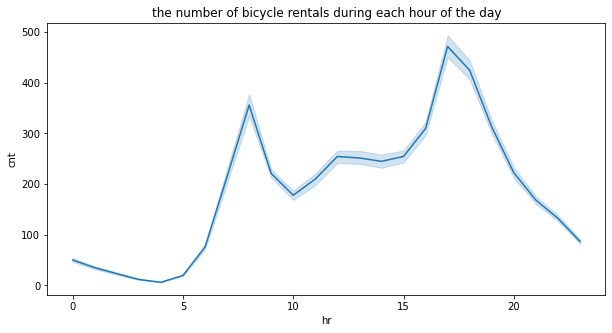

In [36]:
plt.figure(figsize=(10,5))
plt.title('the number of bicycle rentals during each hour of the day')
sns.lineplot(data=train.select("hr", "cnt").toPandas(),x="hr",y="cnt")

In [37]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
 
# Remove the target column from the input feature set.
featuresCols = df.columns
featuresCols.remove('cnt')
 
# vectorAssembler combines all feature columns into a single feature vector column, "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")
 
# vectorIndexer identifies categorical features and indexes them, and creates a new column "features". 
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

In [38]:
from pyspark.ml.regression import GBTRegressor
 
# The next step is to define the model training stage of the pipeline. 
# The following command defines a GBTRegressor model that takes an input column "features" by default and learns to predict the labels in the "cnt" column. 
gbt = GBTRegressor(labelCol="cnt")

In [39]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
 
# Define a grid of hyperparameters to test:
#  - maxDepth: maximum depth of each decision tree 
#  - maxIter: iterations, or the total number of trees 
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5])\
  .addGrid(gbt.maxIter, [10, 100])\
  .build()
 
# Define an evaluation metric.  The CrossValidator compares the true labels with predicted values for each combination of parameters, and calculates this value to determine the best model.
evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())
 
# Declare the CrossValidator, which performs the model tuning.
cv = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [40]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])

In [41]:
pipelineModel = pipeline.fit(train)

22/05/28 23:10:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/28 23:10:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [42]:
predictions = pipelineModel.transform(test)


In [43]:
predictions.select("cnt", "prediction", *featuresCols).limit(3).toPandas()

,cnt,prediction,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,22,32.385369,1,0,1,0,0,0,0,1,0.04,0.0758,0.57,0.1045
1,17,51.698138,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985
2,7,8.728901,1,0,1,0,0,1,1,2,0.24,0.2273,0.65,0.2239


In [44]:
rmse = evaluator.evaluate(predictions)
print("RMSE on our test set: %g" % rmse)

RMSE on our test set: 45.3228


<AxesSubplot:title={'center':'the number of bicycle rentals during each hour of the day'}, xlabel='hr', ylabel='prediction'>

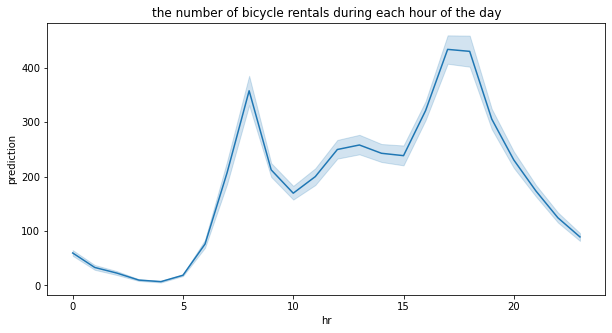

In [46]:
plt.figure(figsize=(10,5))
plt.title('the number of prediction rentals during each hour of the day')
sns.lineplot(data=predictions.select("hr", "prediction").toPandas(),x="hr",y="prediction")

In [48]:
import pyspark.sql.functions as F
predictions_with_residuals = predictions.withColumn("residual", (F.col("cnt") - F.col("prediction")))
predictions_with_residuals.agg({'residual': 'mean'}).limit(3).toPandas()

,avg(residual)
0,0.844374


<AxesSubplot:title={'center':'the residual of bicycle rentals during each hour of the day'}, xlabel='hr', ylabel='residual'>

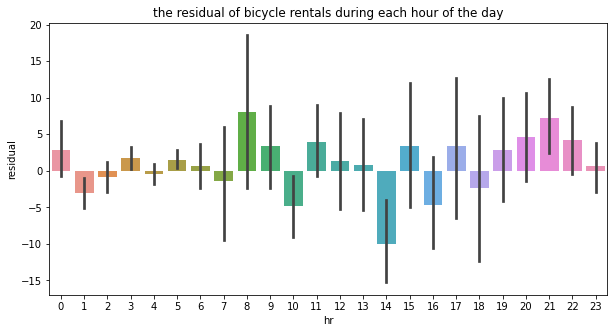

In [52]:
plt.figure(figsize=(10,5))
plt.title('the residual of bicycle rentals during each hour of the day')
sns.barplot(data=predictions_with_residuals.select("hr", "residual").toPandas(),x="hr",y="residual")
